In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, validation_curve
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_classif,  f_classif
from sklearn.metrics import plot_confusion_matrix, classification_report
import zipfile
from pyproj import Proj, transform
import geopandas as gpd
import shapefile
# a nice way of filtering out deprecated warnings
import warnings
import geopandas as gpd
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
trainingdf= pd.read_csv('../preprocessed_data/revisedtrainingdf.csv')
testingdf= pd.read_csv('../preprocessed_data/revisedtestingdf.csv')

X_train=trainingdf.iloc[:, 1:]
y_train=trainingdf.iloc[:,0]
X_test=testingdf.iloc[:,1:]
y_test=testingdf.iloc[:,0]

In [3]:
X_train.columns,  X_test.columns

(Index(['time session', 'PULocationID', 'tip_amount', 'improvement_surcharge',
        'total_amount', 'avespeed_mileshr', 'day', 'DOLocationID',
        'total_trip_duration', 'tempF'],
       dtype='object'),
 Index(['time session', 'PULocationID', 'tip_amount', 'improvement_surcharge',
        'total_amount', 'avespeed_mileshr', 'day', 'DOLocationID',
        'total_trip_duration', 'tempF'],
       dtype='object'))

In [4]:
y_train, y_test

(0         low
 1         med
 2        high
 3         low
 4        high
          ... 
 23342     med
 23343     low
 23344     low
 23345     low
 23346     med
 Name: trip demand, Length: 23347, dtype: object,
 0         med
 1         med
 2         low
 3         low
 4        high
          ... 
 11725     med
 11726     low
 11727     low
 11728     low
 11729     med
 Name: trip demand, Length: 11730, dtype: object)

Training accuracy is:  1.0
Testing accuracy is:  0.8530264279624894


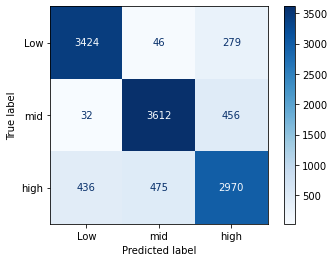

In [29]:
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)
y_pred_training= clf_rf.predict(X_train)
ac = accuracy_score(y_train,y_pred_training)
print('Training accuracy is: ',ac)
y_pred_base= clf_rf.predict(X_test)
ac = accuracy_score(y_test,y_pred_base)
print('Testing accuracy is: ',ac)

plot_confusion_matrix(clf_rf, X_test, y_test,
                                 display_labels= ['Low', "mid","high"],
                                 cmap=plt.cm.Blues)

Training accuracy is 100% where as training accuracy is 85%. This suggests that the data could be overfitting.

In [30]:
print("Model 1: ")
print(classification_report(y_test, y_pred_base))

Model 1: 
              precision    recall  f1-score   support

        high       0.88      0.91      0.90      3749
         low       0.87      0.88      0.88      4100
         med       0.80      0.77      0.78      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730



In [7]:
# Get numerical feature importances
importances = list(clf_rf.feature_importances_)
feature_list= list(X_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: PULocationID         Importance: 0.22
Variable: total_amount         Importance: 0.15
Variable: DOLocationID         Importance: 0.14
Variable: avespeed_mileshr     Importance: 0.13
Variable: total_trip_duration  Importance: 0.11
Variable: tip_amount           Importance: 0.1
Variable: tempF                Importance: 0.05
Variable: time session         Importance: 0.04
Variable: day                  Importance: 0.04
Variable: improvement_surcharge Importance: 0.0


[None, None, None, None, None, None, None, None, None, None]

In [8]:
X_train_2= X_train.drop(columns= "improvement_surcharge")
X_test_2= X_test.drop(columns= "improvement_surcharge")

Training accuracy is:  1.0
Testing accuracy is:  0.8521739130434782


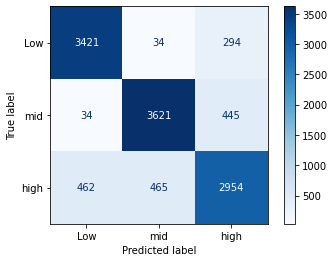

In [53]:
clf_rf_2 = RandomForestClassifier(random_state=43,)      
clr_rf_2 = clf_rf_2.fit(X_train_2,y_train)
y_pred= clf_rf_2.predict(X_train_2)
ac = accuracy_score(y_train,y_pred)
print('Training accuracy is: ',ac)
y_pred_2= clf_rf_2.predict(X_test_2)
ac = accuracy_score(y_test, y_pred_2)
print('Testing accuracy is: ', ac)

plot_confusion_matrix(clf_rf_2, X_test_2, y_test,
                                 display_labels= ['Low', "mid","high"],
                                 cmap=plt.cm.Blues)

In [32]:
print("Base Model:\n", classification_report(y_test, y_pred_base))
print("Model 2:\n", classification_report(y_test, y_pred_2))

Base Model:
               precision    recall  f1-score   support

        high       0.88      0.91      0.90      3749
         low       0.87      0.88      0.88      4100
         med       0.80      0.77      0.78      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730

Model 2:
               precision    recall  f1-score   support

        high       0.87      0.91      0.89      3749
         low       0.88      0.88      0.88      4100
         med       0.80      0.76      0.78      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730



In [33]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [15, 17, 20]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto'], 'max_depth': [15, 17, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5]}


In [34]:
%timeit
rf_random = RandomizedSearchCV(estimator= RandomForestClassifier(random_state=43), param_distributions=random_grid,
                              cv=10, verbose=2,  n_jobs=-1)

# Fit the random search model
print("fitting...")
rf_random.fit(X_train, y_train);

fitting...
Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [36]:
rf_random.best_params_

{'n_estimators': 466,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [43]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=466, random_state=43)

Training accuracy is:  0.9988435345012208
Testing accuracy is:  0.8531969309462916


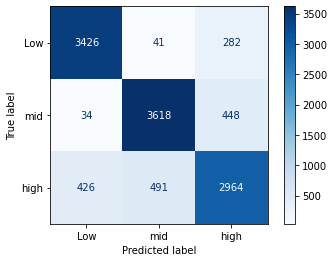

In [63]:
clf_rf_3 = RandomForestClassifier(max_depth=20, n_estimators=466, random_state=43)   
clr_rf_3 = clf_rf_3.fit(X_train, y_train)
y_pred_3= clf_rf_3.predict(X_train)
ac = accuracy_score(y_train,y_pred_3)
print('Training accuracy is: ',ac)
y_pred_3= clf_rf_3.predict(X_test)
ac = accuracy_score(y_test, y_pred_3)
print('Testing accuracy is: ', ac)

plot_confusion_matrix(clf_rf_3, X_test, y_test,
                                 display_labels= ['Low', "mid","high"],
                                 cmap=plt.cm.Blues)

In [64]:
print("Base Model:\n", classification_report(y_test, y_pred_base))
print("Model 3:\n", classification_report(y_test, y_pred_3))

Base Model:
               precision    recall  f1-score   support

        high       0.88      0.91      0.90      3749
         low       0.87      0.88      0.88      4100
         med       0.80      0.77      0.78      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730

Model 3:
               precision    recall  f1-score   support

        high       0.88      0.91      0.90      3749
         low       0.87      0.88      0.88      4100
         med       0.80      0.76      0.78      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730



In [57]:
# Get numerical feature importances
importances = list(clf_rf_3.feature_importances_)
feature_list= list(X_train.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: PULocationID         Importance: 0.22
Variable: total_amount         Importance: 0.15
Variable: DOLocationID         Importance: 0.15
Variable: avespeed_mileshr     Importance: 0.14
Variable: tip_amount           Importance: 0.11
Variable: total_trip_duration  Importance: 0.11
Variable: tempF                Importance: 0.05
Variable: time session         Importance: 0.04
Variable: day                  Importance: 0.04
Variable: improvement_surcharge Importance: 0.0


[None, None, None, None, None, None, None, None, None, None]

Training accuracy is:  0.9988435345012208
Testing accuracy is:  0.8569479965899404


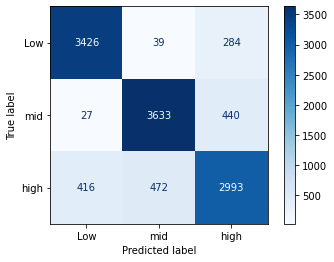

In [59]:
clf_rf_3 = RandomForestClassifier(max_depth=20, n_estimators=466, random_state=43)   
clr_rf_3 = clf_rf_3.fit(X_train_2, y_train)
y_pred_4= clf_rf_3.predict(X_train_2)
ac = accuracy_score(y_train,y_pred_4)
print('Training accuracy is: ',ac)
y_pred_4= clf_rf_3.predict(X_test_2)
ac = accuracy_score(y_test, y_pred_4)
print('Testing accuracy is: ', ac)

plot_confusion_matrix(clf_rf_3, X_test_2, y_test,
                                 display_labels= ['Low', "mid","high"],
                                 cmap=plt.cm.Blues)

In [66]:
print("Base Model:\n", classification_report(y_test, y_pred_base))
print("Model 4:\n", classification_report(y_test, y_pred_4))

Base Model:
               precision    recall  f1-score   support

        high       0.88      0.91      0.90      3749
         low       0.87      0.88      0.88      4100
         med       0.80      0.77      0.78      3881

    accuracy                           0.85     11730
   macro avg       0.85      0.85      0.85     11730
weighted avg       0.85      0.85      0.85     11730

Model 4:
               precision    recall  f1-score   support

        high       0.89      0.91      0.90      3749
         low       0.88      0.89      0.88      4100
         med       0.81      0.77      0.79      3881

    accuracy                           0.86     11730
   macro avg       0.86      0.86      0.86     11730
weighted avg       0.86      0.86      0.86     11730

